In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [4]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


/var/folders/qf/t052sdrx70bffjpl89m9_hz00000gn/T/ipykernel_77168/447971755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [6]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')


In [7]:
df['request_path'].value_counts()

/api/v1/sales?page=2               709
/api/v1/items                      464
/api/v1/items?page=2               291
/api/v1/items?page=3               219
/api/v1/stores                     162
                                  ... 
/api/v1                              1
/api/v1//api/v1/items/next_page      1
/api/v1//api/v1/items                1
/api/v1/items?page=0                 1
/api/V1/HiZach!                      1
Name: request_path, Length: 220, dtype: int64

In [8]:
df['request_path'].value_counts(normalize=True)

/api/v1/sales?page=2               0.050723
/api/v1/items                      0.033195
/api/v1/items?page=2               0.020818
/api/v1/items?page=3               0.015667
/api/v1/stores                     0.011590
                                     ...   
/api/v1                            0.000072
/api/v1//api/v1/items/next_page    0.000072
/api/v1//api/v1/items              0.000072
/api/v1/items?page=0               0.000072
/api/V1/HiZach!                    0.000072
Name: request_path, Length: 220, dtype: float64

In [9]:
df['size'].value_counts()

494819     705
3561       548
3659       291
1328       229
1787       219
          ... 
343913       1
360297       1
327529       1
278377       1
2056327      1
Name: size, Length: 191, dtype: int64

In [10]:
df['request_method'].value_counts()

GET    13978
Name: request_method, dtype: int64

In [11]:
df['http_version'].value_counts()

HTTP/1.1    13978
Name: http_version, dtype: int64

In [12]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [14]:
value_counts_and_frequencies(df.request_path).head()

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590


In [15]:
value_counts_and_frequencies(df.request_path).tail()

,count,proba
/api/v1,1,0.000072
/api/v1//api/v1/items/next_page,1,0.000072
/api/v1//api/v1/items,1,0.000072
/api/v1/items?page=0,1,0.000072
/api/V1/HiZach!,1,0.000072


In [20]:
user=value_counts_and_frequencies(df.user_agent)
user

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072


<AxesSubplot:>

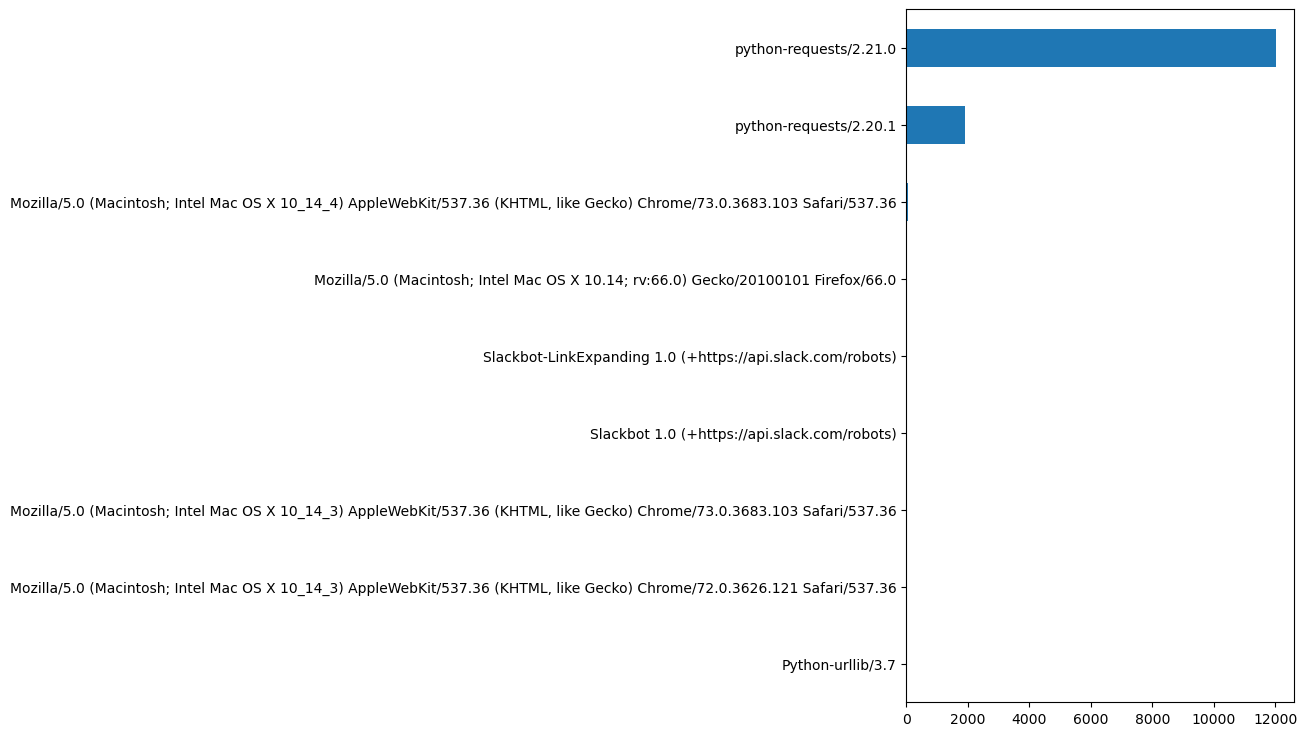

In [21]:
user['count'].sort_values().plot.barh(figsize=(5, 9))
